In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [149]:
class LogLike:
    def __init__(self):
        self.derivative=0
    #log likelihood for easy case, binary 1D
    def forward(self, est, truth):
        self.backward(est, truth)
        return -(truth*np.log((est+1e-7))+(1-truth)*np.log(1-(est-1e-7)))
    
    def backward(self, est, truth):
        #dl/dest
        self.derivative=-(truth/(est+1e-7) + (1-truth)/((est+1e-7)-1))
        return self.derivative
        
class Sigmoid:
    def __init__(self):
        self.derivative=None
        
    def forward(self, in_vec):
        self.backward(1/(1+np.exp(-in_vec)))
        return 1/(1+np.exp(-in_vec))
    
    def backward(self, forwar):
        self.derivative=forwar*(1-forwar)
        return self.derivative
        
        
class ReLU:
    def __init__(self):
        self.derivative=None
        self.test=None
        
    def forward(self, in_vec):
        #batch
        out_vec=in_vec.copy()
        out_vec[out_vec<0]=0
        self.backward(out_vec)
        return out_vec
    
    def backward(self, in_bat):
        vec_derivative=in_bat.copy()
        vec_derivative[vec_derivative!=0]=1
        #print(str(vec_derivative))
        self.derivative=np.empty((in_bat.shape[0],in_bat.shape[1],in_bat.shape[1]))
        for i in range(in_bat.shape[0]):
            self.derivative[i,:,:]=np.diag(vec_derivative[i,:])
        self.test=vec_derivative
        return self.derivative #NxDxD
    

class LinLayer:
    #avec batch proc
    def __init__(self, input_size, output_size):
        self.input_size= input_size
        self.output_size= output_size
        self.weights=np.random.rand(output_size, input_size)*1/np.sqrt(output_size)-(1/np.sqrt(output_size)/2)
        self.bias=np.random.rand(output_size)*1/np.sqrt(output_size)-(1/np.sqrt(output_size)/2)
        self.derivative=np.zeros((output_size, input_size))
        
    def forward(self, in_bat):
        #batch
        self.backward()
        return np.matmul(in_bat, np.transpose(self.weights))+self.bias
    
    def backward(self):
        #for i in range(self.derivate.shape[2]):
            #self.derivate[i,:,i]=self.weights[:,i]
        self.derivative=self.weights
        return self.derivative #dll/dinput
        
    def update(self, dlds, in_vec, eta=0.1):
        #batch
        dldw=np.transpose(dlds)@in_vec[np.newaxis,:]
        dldb=dlds[0]
        self.weights=self.weights-eta*dldw
        self.weights=self.weights.reshape(self.output_size, self.input_size)
        self.bias=self.bias-eta*dldb
        return
    
    
    
def data_gen(N):
    points=np.random.rand(2,N)*2-1
    dist=np.sqrt(points[0,:]**2+points[1,:]**2)
    target=dist.copy()
    target[dist>0.7]=1
    target[dist<=0.7]=0
    target.astype(int)
    plt.scatter(points[0,:],points[1,:],c=target)
    return points,target

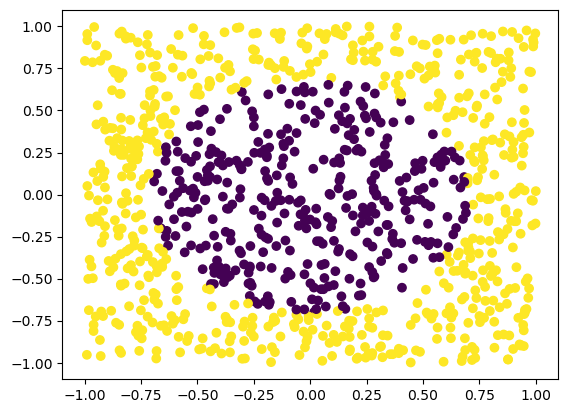

In [158]:
points,target=data_gen(1000)


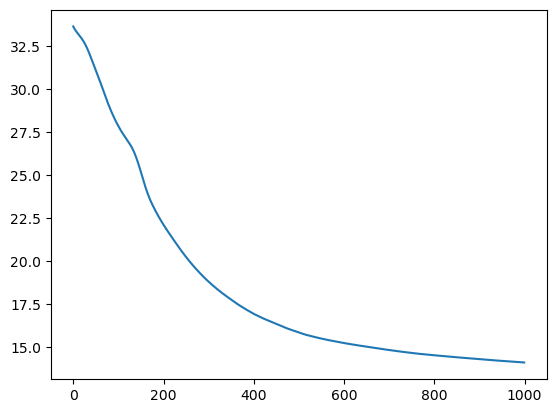

In [167]:
plt.plot(l_arr)

In [166]:
#batch proc

logLik=LogLike()
reLU=ReLU()
linLayer1=LinLayer(2,4)
linLayer2=LinLayer(4,1)
sig=Sigmoid()

B=50 #batch size
l_arr=[]
N=100

batchs=np.array_split(points, B, 1)
targets_b=np.array_split(target, B)
#i=0
for e in range(1000):
    l_temp=0
    #print(e)
    for i in range(B):
        #print(i)
        batch_p=np.transpose(batchs[i]) #NxD
        N_b=batch_p.shape[0]
        batch_t=targets_b[i] #N
        s1=linLayer1.forward(batch_p) #NxH
        h=reLU.forward(s1) #NxH
        s2=linLayer2.forward(h) #Nx1
        y_est=sig.forward(s2) #Nx1
        l=sum(logLik.forward(y_est[:,0], batch_t))/N_b #1

        dldest=logLik.derivative #N
        destds2=sig.derivative #Nx1
        dlds2=logLik.derivative*sig.derivative[:,0] #Nx1
        linLayer2.update(dlds2, h, 0.001)
        ds2dh=linLayer2.derivative #1xH
        #np.tile(ds2dh,(9,1)).shape #NxH
        dhds1=reLU.derivative #NxHxH
        dlds1=dlds2[:,np.newaxis]*(ds2dh @ dhds1).reshape(N_b,4) # Nx1*(NxH) --> NxH
        linLayer1.update(dlds1, batch_p, 0.001)
        
        l_temp=l_temp+l
        
    l_arr.append(l_temp)
        
        
        

9% d'erreur...


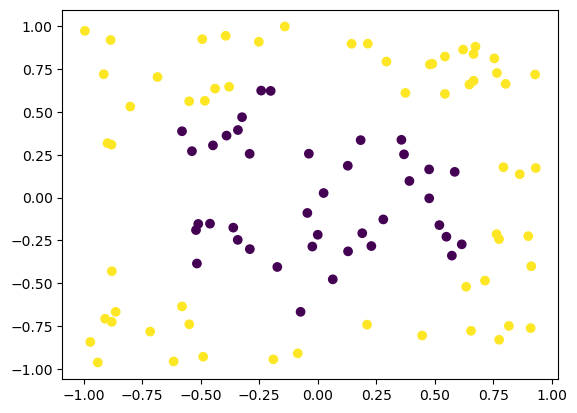

In [183]:
#def error_rate():
B=11 #batch nb
l_arr=[]
N=100



points_val,target_val=data_gen(100)

batchs=np.array_split(points_val, B, 1)
targets_b=np.array_split(target_val, B)

nb_error=0
for i in range(B):
    #print(i)
    batch_p=np.transpose(batchs[i]) #NxD
    N_b=batch_p.shape[0]
    batch_t=targets_b[i] #N
    s1=linLayer1.forward(batch_p) #NxH
    h=reLU.forward(s1) #NxH
    s2=linLayer2.forward(h) #Nx1
    y_est=sig.forward(s2) #Nx1
    
    pred=y_est.copy()
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    
    pred=pred.astype(int)
    nb_error_b=sum(pred[:,0]!=targets_b[i])
    nb_error= nb_error+nb_error_b
    
print(str(nb_error)+"% d'erreur...")

In [180]:
pred.shape

(90, 1)

In [67]:
in_vec=h.copy()
dlds=dlds2.copy()

dldw=np.transpose(dlds)@in_vec[np.newaxis,:]
dldb=dlds[0]


In [134]:
linLayer1.weights

array([[-0.22145641, -0.09622694],
       [-0.12462911,  0.03740286],
       [ 0.24343913,  0.2288627 ],
       [-0.21561173, -0.09058906]])

In [127]:
in_vec = np.transpose(batchs[10])
dlds=dlds1
weights=linLayer1.weights
bias=linLayer1.bias
eta=0.01

dldw=np.transpose(dlds)@in_vec[np.newaxis,:]
dldb=dlds[0]
#weights=weights-eta*dldw
bias=bias-eta*dldb

In [131]:
in_vec

array([[ 0.16381934, -0.24266712],
       [-0.7496261 ,  0.68213589],
       [ 0.29746845,  0.81445167],
       [-0.36002794,  0.97961614],
       [ 0.72059303,  0.75435639],
       [-0.5861877 , -0.08730059],
       [-0.35546961,  0.44643959],
       [ 0.65630926, -0.45878232],
       [ 0.54063439, -0.36092226]])

In [366]:
logLik=LogLike()
reLU=ReLU()
linLayer1=LinLayer(2,4)
linLayer2=LinLayer(4,1)
sig=Sigmoid()

B=11 #batch size
l_arr=[]
N=100

batchs=np.array_split(points, B, 1)
targets_b=np.array_split(target, B)

h=reLU.forward(
            linLayer1.forward(
                np.transpose(batchs[0])
            )
        )
est=sig.forward(
            linLayer2.forward(
                h
            )
        )
l=logLik.forward(est,targets_b[0])

[[1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]]


In [368]:
targets_b[0]

array([1., 0., 1., 1., 1., 1., 1., 0., 1., 0.])

In [165]:
index=0
est=reLU.forward(linLayer.forward(points[:,index]))
l=logLik.forward(est,target[index])
dldx=logLik.derivative
dlds=reLU.derivative*dldx #dl/dx*drelu/ds=dl/ds
dldw=dlds*points[:,index]
dldb=dlds
dldw

/tmp/ipykernel_2678/373228312.py:7: RuntimeWarning: invalid value encountered in log
  return truth*np.log(est)+(1-truth)*np.log(1-est)


array([[0.25487682, 0.3334458 ]])

In [178]:
index=0
est=sig.forward(linLayer.forward(points[:,index]))
l=logLik.forward(est,target[index])
dldx=logLik.derivative
dlds=sig.derivative*dldx #dl/dx*drelu/ds=dl/ds
dldw=dlds*points[:,index]
dldb=dlds
dldw

array([[0.05013704, 0.06559242]])

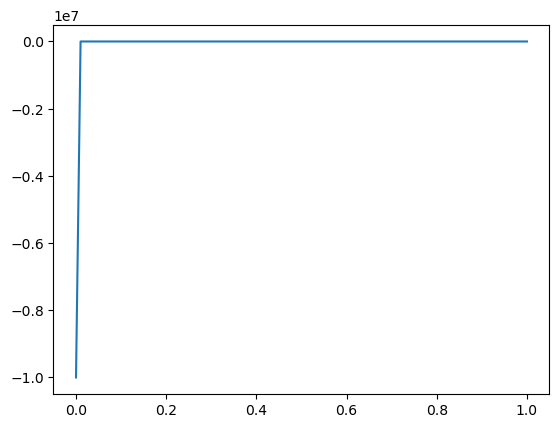

In [323]:

x=np.linspace(0,1,100)
y=np.empty(100)
y_d=np.empty(100)

count=0
for i in x:
    
    y[count]=logLik.forward(i,1)
    y_d[count]=logLik.backward(i,1)
    count=count+1
    
plt.plot(x[0:],y_d[0:])

In [317]:
y_d

array([-1.00000000e+07, -9.89990199e+01, -4.94997550e+01, -3.29998911e+01,
       -2.47499387e+01, -1.97999608e+01, -1.64999728e+01, -1.41428371e+01,
       -1.23749847e+01, -1.09999879e+01, -9.89999020e+00, -8.99999190e+00,
       -8.24999319e+00, -7.61537882e+00, -7.07142357e+00, -6.59999564e+00,
       -6.18749617e+00, -5.82352602e+00, -5.49999698e+00, -5.21052360e+00,
       -4.94999755e+00, -4.71428349e+00, -4.49999798e+00, -4.30434597e+00,
       -4.12499830e+00, -3.95999843e+00, -3.80769086e+00, -3.66666532e+00,
       -3.53571304e+00, -3.41379194e+00, -3.29999891e+00, -3.19354737e+00,
       -3.09374904e+00, -2.99999910e+00, -2.91176386e+00, -2.82857063e+00,
       -2.74999924e+00, -2.67567496e+00, -2.60526248e+00, -2.53846089e+00,
       -2.47499939e+00, -2.41463356e+00, -2.35714230e+00, -2.30232505e+00,
       -2.24999949e+00, -2.19999952e+00, -2.15217345e+00, -2.10638254e+00,
       -2.06249957e+00, -2.02040776e+00, -1.97999961e+00, -1.94117609e+00,
       -1.90384579e+00, -

In [149]:
points[:,index]

array([-0.71006167, -0.08550725])

In [122]:
#data_gen(100)>0.7
#points=np.random.rand(2,100)*2-1
dist=np.sqrt(points[0,:]**2+points[1,:]**2)
target=dist.copy()
target[dist>0.7]=1
target[dist<=0.7]=0
target.astype(int)

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])

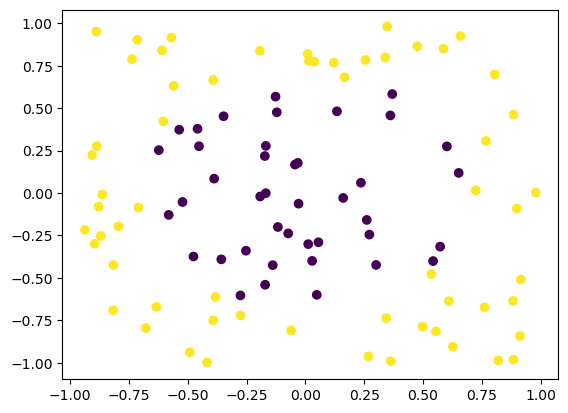

In [127]:
plt.scatter(points[0,:],points[1,:],c=target)

In [19]:
perc.forward(inpout)

array([[4.]])

In [21]:
np.max(inpout,1)

array([1, 2])

In [25]:
np.concatenate((inpout,inpout),1)

array([[1, 1],
       [2, 2]])

In [40]:
x=np.ones((2,2))

In [44]:
x[x==1]=3
x

array([[2., 2.],
       [2., 2.]])

In [55]:
np.diag(inpout[:,0])

array([[1, 0],
       [0, 2]])

In [86]:
inpout=np.array([[-1],[2],[3]])
np.size(inpout)

3

In [89]:
reLU=ReLU(3)
reLU.forward(inpout)
reLU.derivative

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [94]:
np.log(1)

0.0

In [ ]:
# input will be Dx1, D dim size